# Make 3D Data Files

Inversion programs need input data, MTpy has tools for creating model files for various modeling programs.  This is an example for creating a data file for ModEM using the example grid data.

### Imports

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path

from mtpy import MTCollection

## 1. Load in Data

Load in the data created in the first example and get only the data collected on a grid.  Turn those data into a `MTData` object from which we can manipulate the data. 

<div class="alert alert-block alert-info">
    <b>Tip:</b> Using the `with` context manager will close the MTH5 when finished.  This is safer because if something goes wrong the file will always be closed and reduce the chance of corruption. 
</div>


In [3]:
with MTCollection() as mtc:
    mtc.open_collection(Path().cwd().joinpath("test_mt_collection.h5"))
    mtc.working_dataframe = mtc.master_dataframe.loc[mtc.master_dataframe.survey == "grid"]
    mtd = mtc.to_mt_data()

23:10:20T10:27:58 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy-v2\docs\source\notebooks\test_mt_collection.h5


## 2. Calculate Relative Locations

Most modeling programs are agnostic to geographic coordinates as they use a relative coordinate system usually with (0, 0, 0) at one of the corners or the center of the mesh.  Here we assume the center of the station area is the (0, 0) point and relative locations are computed relative to the center point. All relative locations are in meters. 

<div class="alert alert-block alert-warning">
<b>Important:</b> To calculate relative locations you must set the 'utm_epsg' or 'utm_crs' if you have a custom datum.  Once you set the 'utm_crs' or 'utm_epsg' easting and northing is estimated for each station in the MTData object.  This can take a few seconds if there are a lot of stations. 
</div>

Here we will set the EPSG number to WGS84 UTM grid 11N (32611).

<div class="alert alert-block alert-info">
    <b>Tip:</b> To access station locations of the MTData object use MTData.station_locations.  This returns a Pandas DataFrame which can be easily manipulated. 
</div>

<div class="alert alert-block alert-info">
    <b>Tip:</b> The center point is MTData.center_point and is estimated from the station locations in the MTData object.  You can set the center latitude and longitude if you want to offset the center.  
</div>

```
MTData._center_lat = new_center_latitude
MTData._center_lon = new_center_longitude
MTData._center_elev = new_center_elevation
```


In [4]:
mtd.center_point

MT Location: 
--------------------
  Latitude (deg):   38.871946
  Longitude (deg):  -118.192737
  Elevation (m):    0.0000
  Datum crs:        epsg:4326

  Easting (m):      0.000
  Northing (m):     0.000
  UTM crs:          None

  Model Easting (m):      0.000
  Model Northing (m):     0.000
  Model Elevation (m):    0.000
  Profile Offset (m):     0.000

#### Station Locations

You can have a look at the station locations retreived from the MTCollection.  Notice there there are no values for east and north and model_east and model_north yet.   

In [5]:
mtd.station_locations.head(5)

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,model_north,model_elevation,profile_offset
0,grid,gv100,38.611381,-118.535261,1437.40,4326,0.0,0.0,None,0.0,0.0,1437.40,0.0
1,grid,gv101,38.594561,-118.351111,1540.55,4326,0.0,0.0,None,0.0,0.0,1540.55,0.0
2,grid,gv102,38.593692,-118.276822,1554.80,4326,0.0,0.0,None,0.0,0.0,1554.80,0.0
3,grid,gv103,38.585283,-118.202481,1543.90,4326,0.0,0.0,None,0.0,0.0,1543.90,0.0
4,grid,gv104,38.596456,-118.136547,1801.80,4326,0.0,0.0,None,0.0,0.0,1801.80,0.0


#### Set UTM EPSG

Here we set the UTM EPSG number, which creates a `pyproj.CRS` object for easier projection between coordinate systems, mainly from degrees to meters.  If you created your own CRS you can set the CRS directly, see [pyproj.CRS](https://pyproj4.github.io/pyproj/dev/api/crs/crs.html) for details on creating a custom CRS. Once either the `utm_epsg` or `utm_crs` is set northing and easting for each station in the MTData object is calculated and the station locations are updated, which updates the center point.  

In [6]:
mtd.utm_epsg = 32611

In [7]:
mtd.center_point

MT Location: 
--------------------
  Latitude (deg):   38.873786
  Longitude (deg):  -118.196245
  Elevation (m):    0.0000
  Datum crs:        epsg:4326

  Easting (m):      396229.649
  Northing (m):     4303450.537
  UTM crs:          epsg:32611

  Model Easting (m):      396229.649
  Model Northing (m):     4303450.537
  Model Elevation (m):    0.000
  Profile Offset (m):     0.000

In [8]:
mtd.station_locations.head(5)

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,model_north,model_elevation,profile_offset
0,grid,gv100,38.611381,-118.535261,1437.40,4326,366331.327569,4.274770e+06,32611,0.0,0.0,1437.40,0.0
1,grid,gv101,38.594561,-118.351111,1540.55,4326,382337.730338,4.272652e+06,32611,0.0,0.0,1540.55,0.0
2,grid,gv102,38.593692,-118.276822,1554.80,4326,388806.125501,4.272463e+06,32611,0.0,0.0,1554.80,0.0
3,grid,gv103,38.585283,-118.202481,1543.90,4326,395268.278608,4.271442e+06,32611,0.0,0.0,1543.90,0.0
4,grid,gv104,38.596456,-118.136547,1801.80,4326,401026.349952,4.272609e+06,32611,0.0,0.0,1801.80,0.0


#### Calculate Relative Locations

Now that we have easting and northing we can estimate relative locations in model coordinates, which assumes the center of the station area is (0, 0).  If you want to offset the center set these values to your desired center location.

```
MTData._center_lat = new_center_latitude
MTData._center_lon = new_center_longitude
MTData._center_elev = new_center_elevation
```

The method to use is `compute_relative_locations()`.  It iterates over the stations and removes the center point from the easting and northing.

In [9]:
mtd.compute_relative_locations()

Now we have relative locations.

In [10]:
mtd.station_locations.head(5)

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,model_north,model_elevation,profile_offset
0,grid,gv100,38.611381,-118.535261,1437.40,4326,366331.327569,4.274770e+06,32611,-29898.321606,-28680.329764,1437.40,0.0
1,grid,gv101,38.594561,-118.351111,1540.55,4326,382337.730338,4.272652e+06,32611,-13891.918837,-30798.871440,1540.55,0.0
2,grid,gv102,38.593692,-118.276822,1554.80,4326,388806.125501,4.272463e+06,32611,-7423.523674,-30987.924124,1554.80,0.0
3,grid,gv103,38.585283,-118.202481,1543.90,4326,395268.278608,4.271442e+06,32611,-961.370567,-32008.380683,1543.90,0.0
4,grid,gv104,38.596456,-118.136547,1801.80,4326,401026.349952,4.272609e+06,32611,4796.700777,-30841.737287,1801.80,0.0


## 3. Compute Model Errors

After getting relative locations we can now calculate model errors.  These are often larger than measurement error.  People have their favorite method of estimating errors and we have tried to accommodate most.  If there isn't one here try adding to `mtpy.modeling.errors` or raise an issue.  Supported so far are:

| Name | Description | Example |
|------|-------------|---------|
| geometric_mean | Geometric mean of the off-diagonal components of the impedance tensor, or components of the induction vectors. | error_value $\cdot \sqrt(Z_{xy} \cdot Z_{yx})$ | 
| arithmetic_mean | Arithmetic mean of off-diagonal components of the impedance tensor, or components of the induction vectors. | error_value$\cdot (Z_{xy} + Z_{yx}) / 2$ | 
| row | Error per row of the impedance tensor | error_value $\cdot Z_{xy}$  |
| median | Median of the off-diagnoal components | error_value $\cdot median([Z_{xy}, Z{yx}])$ | 
| eigen | Maximum Eigen value of the impedance tensor | error_value x eigen(Z) | 
| percent | Percent error per component | error_value $\cdot Z_{ij}$ | 
| absolute | Absolute error | error_value |

#### Setting Impedance Error
MTData has an attribute `z_model_error` that is an `mtpy.modeling.errors.ModelErrors` object.  It has some default values, which seem fine for now.  But if you want to change any you can use:

```
mtd.z_model_error.error_type = "row"
mtd.z_model_error.error_value = 10   # for 10 percent
mtd.z.model_error.floor = False      # use the calculated value not as a floor for measured errors but absolute value.
```


In [11]:
mtd.z_model_error

Model Errors:
--------------------
	error_type:    geometric_mean
	error_value:   0.05
	floor:         True
	mode:          impedance

#### Setting Tipper Error

Similar to the impedance MTData has an attribute `t_model_error` and is a `mtpy.modeling.errors.ModelErrors` object.

In [12]:
mtd.t_model_error

Model Errors:
--------------------
	error_type:    absolute
	error_value:   0.02
	floor:         True
	mode:          tipper

### Calculate Model Errors

Once you set `z_model_error` and `t_model_error` paramters then run `MTData.compute_model_errors()`

<div class="alert alert-block alert-info">
    <b>Tip:</b> compute_model_errors accepts key words that can be used to set z_model_error and t_model_error
</div>

In [13]:
mtd.compute_model_errors(z_error_value=7)

In [14]:
mtd["grid.gv100"].impedance[0:1]

<xarray.DataArray 'impedance' (period: 1, output: 2, input: 2)>
array([[[ -86.57589 -714.197j, 1090.806  +2750.944j],
        [-115.5849 +1316.743j, -683.7422 -5020.612j]]])
Coordinates:
  * output   (output) <U2 'ex' 'ey'
  * input    (input) <U2 'hx' 'hy'
  * period   (period) float64 0.001302
Attributes:
    survey:             grid
    project:            Energy Resources Program
    id:                 gv100
    name:               None
    latitude:           38.611380555555556
    longitude:          -118.53526111111111
    elevation:          1437.4
    declination:        12.5
    datum:              WGS84
    acquired_by:        Jared Peacock
    start:              2020-08-19T00:00:00+00:00
    end:                1980-01-01T00:00:00+00:00
    runs_processed:     ['gv100a']
    coordinate_system:  geographic

In [15]:
mtd["grid.gv100"].impedance_error[0:1]

<xarray.DataArray 'impedance_error' (period: 1, output: 2, input: 2)>
array([[[ 98.57316572, 237.08819034],
        [249.77736086, 600.78698388]]])
Coordinates:
  * output   (output) <U2 'ex' 'ey'
  * input    (input) <U2 'hx' 'hy'
  * period   (period) float64 0.001302
Attributes:
    survey:             grid
    project:            Energy Resources Program
    id:                 gv100
    name:               None
    latitude:           38.611380555555556
    longitude:          -118.53526111111111
    elevation:          1437.4
    declination:        12.5
    datum:              WGS84
    acquired_by:        Jared Peacock
    start:              2020-08-19T00:00:00+00:00
    end:                1980-01-01T00:00:00+00:00
    runs_processed:     ['gv100a']
    coordinate_system:  geographic

In [16]:
mtd["grid.gv100"].impedance_model_error[0:1]

<xarray.DataArray 'impedance_model_error' (period: 1, output: 2, input: 2)>
array([[[138.44510952, 237.08819034],
        [249.77736086, 600.78698388]]])
Coordinates:
  * output   (output) <U2 'ex' 'ey'
  * input    (input) <U2 'hx' 'hy'
  * period   (period) float64 0.001302
Attributes:
    survey:             grid
    project:            Energy Resources Program
    id:                 gv100
    name:               None
    latitude:           38.611380555555556
    longitude:          -118.53526111111111
    elevation:          1437.4
    declination:        12.5
    datum:              WGS84
    acquired_by:        Jared Peacock
    start:              2020-08-19T00:00:00+00:00
    end:                1980-01-01T00:00:00+00:00
    runs_processed:     ['gv100a']
    coordinate_system:  geographic

You can see with the floor set measurement error are used if the value is above the estimated error from the parameters set above. And using an absolute error we see the value is set for all elements in the induction vectors.

In [17]:
mtd["grid.gv100"].tipper_model_error[0:1]

<xarray.DataArray 'tipper_model_error' (period: 1, output: 1, input: 2)>
array([[[0.02, 0.02]]])
Coordinates:
  * output   (output) <U2 'hz'
  * input    (input) <U2 'hx' 'hy'
  * period   (period) float64 0.001302
Attributes:
    survey:             grid
    project:            Energy Resources Program
    id:                 gv100
    name:               None
    latitude:           38.611380555555556
    longitude:          -118.53526111111111
    elevation:          1437.4
    declination:        12.5
    datum:              WGS84
    acquired_by:        Jared Peacock
    start:              2020-08-19T00:00:00+00:00
    end:                1980-01-01T00:00:00+00:00
    runs_processed:     ['gv100a']
    coordinate_system:  geographic

## 4. Plot Stations

Plot relative station locations.


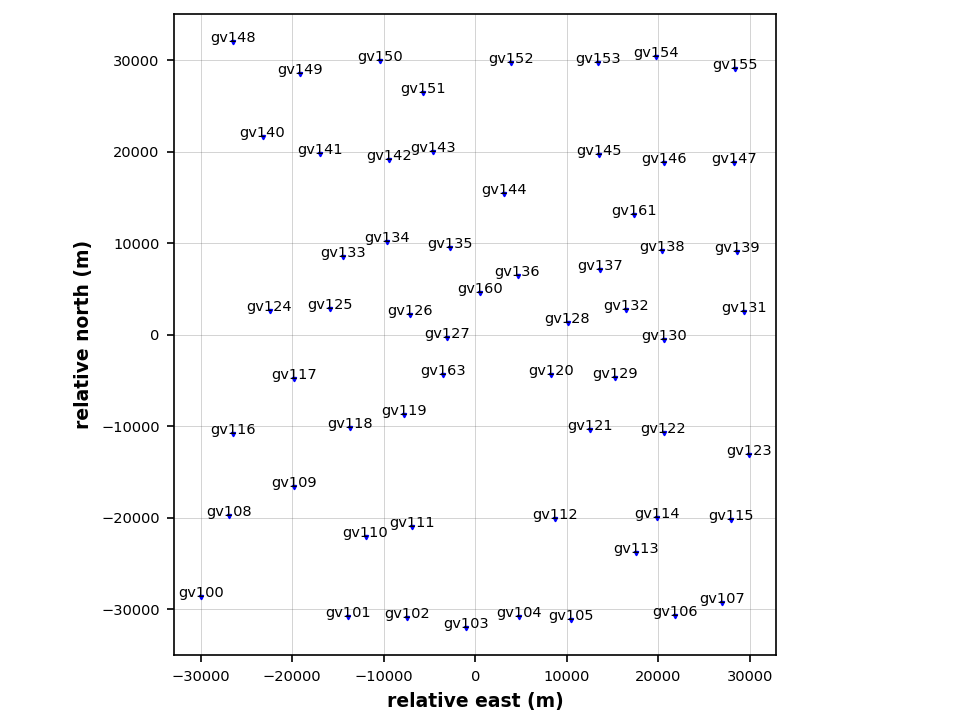

In [18]:
plot_stations = mtd.plot_stations(model_locations=True)

## 4. Write to file

Now that the data have been updated with locations and weights we can write to a file.  Here we will write to a file for ModEM.

In [19]:
modem_data_object = mtd.to_modem_data(Path().cwd().joinpath("example_modem_data_file.dat"))

23:10:20T10:28:12 | WARNING | line:678 |mtpy.modeling.modem.data | _check_for_errors_of_zero | Found errors with values of 0 in zxx 40 times. Setting error as zxx x 0.07.
23:10:20T10:28:12 | WARNING | line:678 |mtpy.modeling.modem.data | _check_for_errors_of_zero | Found errors with values of 0 in zxy 40 times. Setting error as zxy x 0.07.
23:10:20T10:28:12 | WARNING | line:678 |mtpy.modeling.modem.data | _check_for_errors_of_zero | Found errors with values of 0 in zyx 40 times. Setting error as zyx x 0.07.
23:10:20T10:28:12 | WARNING | line:678 |mtpy.modeling.modem.data | _check_for_errors_of_zero | Found errors with values of 0 in zyy 40 times. Setting error as zyy x 0.07.
23:10:20T10:28:12 | WARNING | line:709 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in zxx 3 times. Setting error as zxx x 0.07.
23:10:20T10:28:12 | WARNING | line:709 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.

In [20]:
modem_data_object

ModEM Data Object:
	Number of impedance stations: 59
	Number of tipper stations: 59
	Number of phase tensor stations: 0
	Number of periods:  168
	Period range (s):  
		Min: 0.0013021
		Max: 2048
	Rotation angle:     0
	Data center:        
		Latitude:   38.8738 deg 	Northing: 4303450.5370 m
		Longitude: -118.1962 deg 	Easting: 396229.6492 m
		Datum epsg: 4326			UTM epsg:   32611
		Elevation:  0.0 m
	Impedance data:     True
	Tipper data:        True
	Inversion Mode:   Full_Impedance, Full_Vertical_Components